In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import loadmat
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Entropy of Real Cell

In [5]:
def Entropy(rstate, binnum, overlap = True):
    rstate[rstate>1] = 1
    wordsCollection = []
    if overlap:
        for i in np.arange(0,len(rstate)-binnum+1):
            wordsCollection.append(rstate[i:i+binnum])
    else:
        for i in np.arange(0,len(rstate)-binnum+1,binnum):
            wordsCollection.append(rstate[i:i+binnum])
    _, index = np.unique(np.array(wordsCollection), axis = 0, return_inverse=True)
    N, _ = np.histogram(index,bins=np.append(np.unique(index),max(index)))
    P = N/np.sum(N)
    entropy = -np.sum(P*np.log2(P))
    return entropy

# Load files

In [6]:
dt = 0.01
exp_folder = 'D:\\GoogleDrive\\retina\\Exps\\2021\\1117\\SplitData\\'
Mean_list = [1,4,7,10,13]
Contrast_list = [0.05,0.1,0.2,0.3]

Data2DList = [[{} for c in Contrast_list] for m in Mean_list]
for mi in range(len(Mean_list)):
    for ci in range(len(Contrast_list)):
        filename = 'diode_repeat_OU_tau=500ms_cutoff=1_mean='+str(Mean_list[mi])+'_C='+str(Contrast_list[ci])+'_17-Nov-2021_0'
        annots = loadmat(exp_folder+filename, squeeze_me = True)
        sampling_rate = 20000
        TicTocer = annots['a_data'][1]
        startTime = np.where(TicTocer>38000)[0][0]/sampling_rate
        endTime = np.where(TicTocer>38000)[0][-1]/sampling_rate+300
        x = annots['a_data'][0, int(startTime*sampling_rate):int(endTime*sampling_rate)+1]
        x = x[::int(sampling_rate*dt)]
        x = x.astype(float)
        x = (x-np.mean(x))/np.std(x)
        T = np.arange(len(x))*dt

        Spike_Cell = [0]*60
        for channelnumber in np.arange(1,61):
            if channelnumber in [4,53,60]: continue
            Spike = annots['Spikes'][channelnumber-1]
            try:
                Spike_Cell[channelnumber-1] = Spike[np.where(Spike>startTime)[0][0]:np.where(Spike<endTime)[0][-1]]-startTime
            except: # no spike
                Spike_Cell[channelnumber-1] = np.array([])

        Data2DList[mi][ci]['Mean']       = Mean_list[mi]
        Data2DList[mi][ci]['Contrast']   = Contrast_list[ci]
        Data2DList[mi][ci]['input']      = x.copy()
        Data2DList[mi][ci]['timeAxis']   = T.copy()
        Data2DList[mi][ci]['Spike_Cell'] = Spike_Cell.copy()

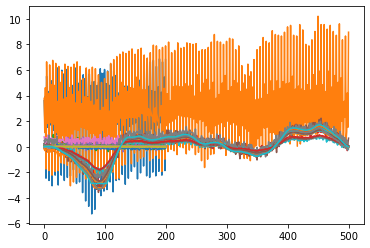

In [7]:
restTime = 2
stiTime = 5
trial = 85

for data in np.array(Data2DList).flatten():
    x = data['input']
    plt.plot(x[:int(restTime/dt)])
    plt.plot(x[int(restTime/dt):int((restTime+stiTime)/dt)])

In [8]:
for mi in range(len(Mean_list)):
    for ci in range(len(Contrast_list)):
        x_trial = [0]*trial
        delayCorrection = [0]*trial
        for i in range(trial):
            startTime = restTime+i*(restTime+stiTime)
            endTime = (i+1)*(restTime+stiTime)
            x_trial[i] = Data2DList[mi][ci]['input'][int(startTime/dt):int(endTime/dt)]
            if i == 0:
                center = np.argmax(np.correlate(x_trial[0], x_trial[0], 'same'))
            else:
                delayCorrection[i] = np.argmax(np.correlate(x_trial[i], x_trial[0], 'same'))-center

        Data2DList[mi][ci]['delayCorrection'] = delayCorrection.copy()

In [86]:
# Data2DList[mi][ci]['delayCorrection']

# Information (R_info)

In [10]:
def R_info(rstate_trial, binnum, overlap = False):
    rstate_trial = np.array(rstate_trial)
    wordsCollection = []
    for rstate in rstate_trial:
        rstate[rstate>1] = 1
        if overlap:
            for i in np.arange(0,len(rstate)-binnum+1):
                wordsCollection.append(rstate[i:i+binnum])
        else:
            for i in np.arange(0,len(rstate)-binnum+1,binnum):
                wordsCollection.append(rstate[i:i+binnum])
    _, index = np.unique(np.array(wordsCollection), axis = 0, return_inverse=True)
    N, _ = np.histogram(index,bins=np.append(np.unique(index),max(index)))
    P = N/np.sum(N)
    totalEntropy = -np.sum(P*np.log2(P))

    trial_num = rstate_trial.shape[0]
    event_num = int(len(wordsCollection)/rstate_trial.shape[0])

    subEntropy = 0
    for i in range(event_num):
        subSet = []
        for j in range(trial_num):
            subSet.append(wordsCollection[event_num*j+i])
        _, index = np.unique(np.array(subSet), axis = 0, return_inverse=True)
        N, _ = np.histogram(index,bins=np.append(np.unique(index),max(index)))
        P = N/np.sum(N)
        subEntropy += -np.sum(P*np.log2(P))
    
    noiseEntropy = subEntropy/event_num
    return totalEntropy, noiseEntropy

In [11]:
binLen = dt/10
binNum = 10

## Cut Trial

In [12]:
for mi in range(len(Mean_list)):
    for ci in range(len(Contrast_list)):
        if mi == 2 and ci == 3: continue
        Spike_Cell = Data2DList[mi][ci]['Spike_Cell'].copy()

        totalEntropy_Cell = [0]*60
        noiseEntropy_Cell = [0]*60
        Spike_Trial_Cell = [0]*60
        rest_totalEntropy_Cell = [0]*60
        rest_noiseEntropy_Cell = [0]*60
        rest_Spike_Trial_Cell = [0]*60
        for cn in range(60):
            if cn in [3,52,59]: continue
            Spike = Spike_Cell[cn]

            rstate_Trial = [0]*trial
            rest_rstate_Trial = [0]*trial
            Spike_Trial = [-1]*trial
            rest_Spike_Trial = [-1]*trial
            for i in range(trial):
                # for stimulated
                startTime = restTime+i*(restTime+stiTime)+Data2DList[mi][ci]['delayCorrection'][i]*dt
                endTime = (i+1)*(restTime+stiTime)+Data2DList[mi][ci]['delayCorrection'][i]*dt
                try:
                    Spike_Trial[i] = Spike[np.where(Spike>=startTime)[0][0]:np.where(Spike<endTime)[0][-1]]-startTime
                    rstate_Trial[i], _ = np.histogram(Spike_Trial[i], np.arange(0,stiTime+binLen,binLen))
                except: # if there is no spike
                    rstate_Trial[i] = np.zeros(int(stiTime/binLen)+1)
                # for at rest
                startTime = i*(restTime+stiTime)+Data2DList[mi][ci]['delayCorrection'][i]*dt
                endTime = restTime+i*(restTime+stiTime)+Data2DList[mi][ci]['delayCorrection'][i]*dt
                try:
                    rest_Spike_Trial[i] = Spike[np.where(Spike>=startTime)[0][0]:np.where(Spike<endTime)[0][-1]]-startTime
                    rest_rstate_Trial[i], _ = np.histogram(rest_Spike_Trial[i], np.arange(0,stiTime+binLen,binLen))
                except: # if there is no spike
                    rest_rstate_Trial[i] = np.zeros(int(stiTime/binLen)+1)
            Spike_Trial_Cell[cn] = Spike_Trial.copy()
            rest_Spike_Trial_Cell[cn] = rest_Spike_Trial.copy()
            totalEntropy_Cell[cn], noiseEntropy_Cell[cn] = R_info(rstate_Trial, binNum)
            rest_totalEntropy_Cell[cn], rest_noiseEntropy_Cell[cn] = R_info(rest_rstate_Trial, binNum)

        Data2DList[mi][ci]['Spike_Trial_Cell'] = np.array(Spike_Trial_Cell)
        Data2DList[mi][ci]['rest_Spike_Trial_Cell'] = np.array(rest_Spike_Trial_Cell)
        Data2DList[mi][ci]['totalEntropy_Cell'] = np.array(totalEntropy_Cell)
        Data2DList[mi][ci]['noiseEntropy_Cell'] = np.array(noiseEntropy_Cell)
        Data2DList[mi][ci]['rest_totalEntropy_Cell'] = np.array(rest_totalEntropy_Cell)
        Data2DList[mi][ci]['rest_noiseEntropy_Cell'] = np.array(rest_noiseEntropy_Cell)

Text(0, 0.5, 'information (bit)')

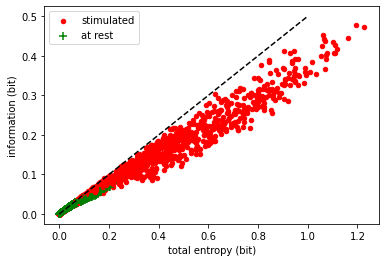

In [13]:
for data in np.array(Data2DList).flatten():
    if data['Mean'] == 7 and data['Contrast'] == 0.3: continue
    totalEntropy_Cell = data['totalEntropy_Cell']
    noiseEntropy_Cell = data['noiseEntropy_Cell']
    plt.scatter(totalEntropy_Cell,totalEntropy_Cell-noiseEntropy_Cell, s =20, c = 'r')

    rest_totalEntropy_Cell = data['rest_totalEntropy_Cell']
    rest_noiseEntropy_Cell = data['rest_noiseEntropy_Cell']
    plt.scatter(rest_totalEntropy_Cell,rest_totalEntropy_Cell-rest_noiseEntropy_Cell, s =50, c = 'g', marker='+')
plt.legend(('stimulated', 'at rest'))
plt.plot([0, 1.], [0, 0.5], 'k--')
plt.xlabel('total entropy (bit)')
plt.ylabel('information (bit)')

Text(0, 0.5, 'information per spike (bit/Spike)')

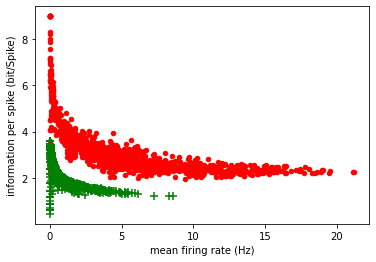

In [81]:
for data in np.array(Data2DList).flatten():
    if data['Mean'] == 7 and data['Contrast'] == 0.3: continue
    Spike_Trial_Cell = data['Spike_Trial_Cell'].copy()
    totalEntropy_Cell = data['totalEntropy_Cell']
    noiseEntropy_Cell = data['noiseEntropy_Cell']
    for cn in range(60):
        if cn in [3,52,59]: continue
        totalSpikeCount = 0
        for Spike in Spike_Trial_Cell[cn]:
            try:
                totalSpikeCount+=len(Spike)
            except:
                continue
        plt.scatter(totalSpikeCount/stiTime/trial, 
                    (totalEntropy_Cell[cn]-noiseEntropy_Cell[cn])/binNum/binLen / (totalSpikeCount/stiTime/trial) , s =20, c = 'r')

for data in np.array(Data2DList).flatten():
    if data['Mean'] == 7 and data['Contrast'] == 0.3: continue
    Spike_Trial_Cell = data['rest_Spike_Trial_Cell'].copy()
    totalEntropy_Cell = data['rest_totalEntropy_Cell']
    noiseEntropy_Cell = data['rest_noiseEntropy_Cell']
    for cn in range(60):
        if cn in [3,52,59]: continue
        totalSpikeCount = 0
        for Spike in Spike_Trial_Cell[cn]:
            try:
                totalSpikeCount+=len(Spike)
            except:
                continue
        
        plt.scatter(totalSpikeCount/restTime/trial,
                    (totalEntropy_Cell[cn]-noiseEntropy_Cell[cn])/binNum/binLen / (totalSpikeCount/restTime/trial), s =50, c = 'g', marker='+')

plt.xlabel('mean firing rate (Hz)')
plt.ylabel('information per spike (bit/Spike)')

Text(0, 0.5, 'information per spike (bit/s)')

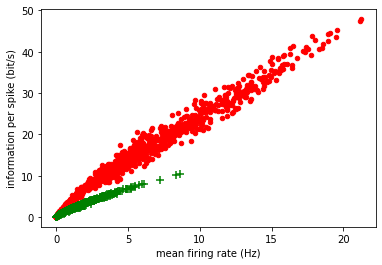

In [85]:
for data in np.array(Data2DList).flatten():
    if data['Mean'] == 7 and data['Contrast'] == 0.3: continue
    Spike_Trial_Cell = data['Spike_Trial_Cell'].copy()
    totalEntropy_Cell = data['totalEntropy_Cell']
    noiseEntropy_Cell = data['noiseEntropy_Cell']
    for cn in range(60):
        if cn in [3,52,59]: continue
        totalSpikeCount = 0
        for Spike in Spike_Trial_Cell[cn]:
            try:
                totalSpikeCount+=len(Spike)
            except:
                continue
        plt.scatter(totalSpikeCount/stiTime/trial, 
                    (totalEntropy_Cell[cn]-noiseEntropy_Cell[cn])/binNum/binLen , s =20, c = 'r')

for data in np.array(Data2DList).flatten():
    if data['Mean'] == 7 and data['Contrast'] == 0.3: continue
    Spike_Trial_Cell = data['rest_Spike_Trial_Cell'].copy()
    totalEntropy_Cell = data['rest_totalEntropy_Cell']
    noiseEntropy_Cell = data['rest_noiseEntropy_Cell']
    for cn in range(60):
        if cn in [3,52,59]: continue
        totalSpikeCount = 0
        for Spike in Spike_Trial_Cell[cn]:
            try:
                totalSpikeCount+=len(Spike)
            except:
                continue
        
        plt.scatter(totalSpikeCount/restTime/trial,
                    (totalEntropy_Cell[cn]-noiseEntropy_Cell[cn])/binNum/binLen , s =50, c = 'g', marker='+')

plt.xlabel('mean firing rate (Hz)')
plt.ylabel('information per spike (bit/s)')

Text(0, 0.5, 'efficiency')

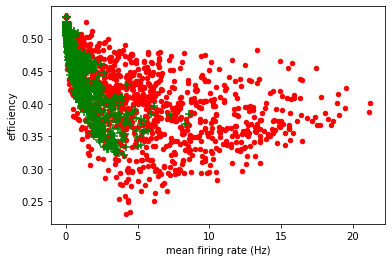

In [80]:
for data in np.array(Data2DList).flatten():
    if data['Mean'] == 7 and data['Contrast'] == 0.3: continue
    Spike_Trial_Cell = data['Spike_Trial_Cell'].copy()
    totalEntropy_Cell = data['totalEntropy_Cell']
    noiseEntropy_Cell = data['noiseEntropy_Cell']
    for cn in range(60):
        if cn in [3,52,59]: continue
        totalSpikeCount = 0
        for Spike in Spike_Trial_Cell[cn]:
            try:
                totalSpikeCount+=len(Spike)
            except:
                continue
        plt.scatter(totalSpikeCount/stiTime/trial, (totalEntropy_Cell[cn]-noiseEntropy_Cell[cn])/totalEntropy_Cell[cn], s =20, c = 'r')

for data in np.array(Data2DList).flatten():
    if data['Mean'] == 7 and data['Contrast'] == 0.3: continue
    Spike_Trial_Cell = data['rest_Spike_Trial_Cell'].copy()
    totalEntropy_Cell = data['rest_totalEntropy_Cell']
    noiseEntropy_Cell = data['rest_noiseEntropy_Cell']
    for cn in range(60):
        if cn in [3,52,59]: continue
        totalSpikeCount = 0
        for Spike in Spike_Trial_Cell[cn]:
            try:
                totalSpikeCount+=len(Spike)
            except:
                continue
        plt.scatter(totalSpikeCount/restTime/trial, (totalEntropy_Cell[cn]-noiseEntropy_Cell[cn])/totalEntropy_Cell[cn], s =50, c = 'g', marker='+')

plt.xlabel('mean firing rate (Hz)')
plt.ylabel('efficiency')

Text(0.5, 0, 'efficiency')

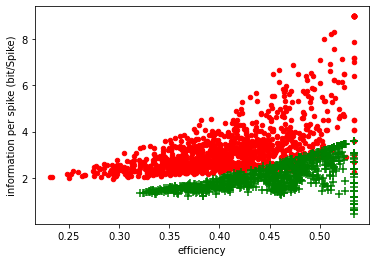

In [82]:
for data in np.array(Data2DList).flatten():
    if data['Mean'] == 7 and data['Contrast'] == 0.3: continue
    Spike_Trial_Cell = data['Spike_Trial_Cell'].copy()
    totalEntropy_Cell = data['totalEntropy_Cell']
    noiseEntropy_Cell = data['noiseEntropy_Cell']
    for cn in range(60):
        if cn in [3,52,59]: continue
        totalSpikeCount = 0
        for Spike in Spike_Trial_Cell[cn]:
            try:
                totalSpikeCount+=len(Spike)
            except:
                continue
        plt.scatter((totalEntropy_Cell[cn]-noiseEntropy_Cell[cn])/totalEntropy_Cell[cn], 
                    (totalEntropy_Cell[cn]-noiseEntropy_Cell[cn])/binNum/binLen / (totalSpikeCount/stiTime/trial) , s =20, c = 'r')

for data in np.array(Data2DList).flatten():
    if data['Mean'] == 7 and data['Contrast'] == 0.3: continue
    Spike_Trial_Cell = data['rest_Spike_Trial_Cell'].copy()
    totalEntropy_Cell = data['rest_totalEntropy_Cell']
    noiseEntropy_Cell = data['rest_noiseEntropy_Cell']
    for cn in range(60):
        if cn in [3,52,59]: continue
        totalSpikeCount = 0
        for Spike in Spike_Trial_Cell[cn]:
            try:
                totalSpikeCount+=len(Spike)
            except:
                continue
        
        plt.scatter((totalEntropy_Cell[cn]-noiseEntropy_Cell[cn])/totalEntropy_Cell[cn],
                    (totalEntropy_Cell[cn]-noiseEntropy_Cell[cn])/binNum/binLen / (totalSpikeCount/restTime/trial), s =50, c = 'g', marker='+')

plt.ylabel('information per spike (bit/Spike)')
plt.xlabel('efficiency')

# DCCM

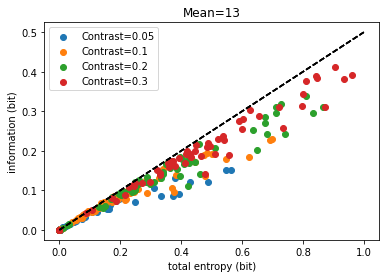

In [57]:
mi = 4
for ci in range(len(Contrast_list)):
    if mi == 2 and ci == 3: continue
    totalEntropy_Cell = Data2DList[mi][ci]['totalEntropy_Cell']
    noiseEntropy_Cell = Data2DList[mi][ci]['noiseEntropy_Cell']
    plt.scatter(totalEntropy_Cell,totalEntropy_Cell-noiseEntropy_Cell, label = 'Contrast='+str(Contrast_list[ci]))
    plt.plot([0, 1.], [0, 0.5], 'k--')
plt.xlabel('total entropy (bit)')
plt.ylabel('information (bit)')
plt.title('Mean='+str(Mean_list[mi]))
plt.legend()

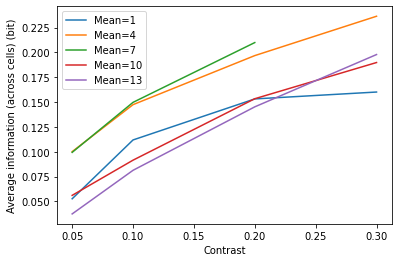

In [58]:
for mi in range(len(Mean_list)):
    mean_totalEntropy = np.zeros(len(Contrast_list))
    mean_noiseEntropy = np.zeros(len(Contrast_list))
    for ci in range(len(Contrast_list)):
        if mi == 2 and ci == 3: continue
        mean_totalEntropy[ci] = np.mean(np.array(Data2DList[mi][ci]['totalEntropy_Cell']))
        mean_noiseEntropy[ci] = np.mean(np.array(Data2DList[mi][ci]['noiseEntropy_Cell']))
    # plt.plot(Contrast_list,mean_totalEntropy, label = 'Mean='+str(Mean_list[mi]))
    if mi == 2 : 
        plt.plot(Contrast_list[:-1], (mean_totalEntropy-mean_noiseEntropy)[:-1], label = 'Mean='+str(Mean_list[mi]))
    else:
        plt.plot(Contrast_list, mean_totalEntropy-mean_noiseEntropy, label = 'Mean='+str(Mean_list[mi]))

    
    # plt.plot(Contrast_list, (mean_totalEntropy-mean_noiseEntropy)/mean_totalEntropy , label = 'Mean='+str(Mean_list[mi]))
plt.xlabel('Contrast')
plt.ylabel('Average information (across cells) (bit)')
plt.legend()

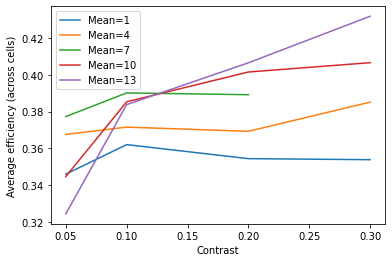

In [59]:
for mi in range(len(Mean_list)):
    mean_totalEntropy = np.zeros(len(Contrast_list))
    mean_noiseEntropy = np.zeros(len(Contrast_list))
    for ci in range(len(Contrast_list)):
        if mi == 2 and ci == 3: continue
        mean_totalEntropy[ci] = np.mean(np.array(Data2DList[mi][ci]['totalEntropy_Cell']))
        mean_noiseEntropy[ci] = np.mean(np.array(Data2DList[mi][ci]['noiseEntropy_Cell']))
    # plt.plot(Contrast_list,mean_totalEntropy, label = 'Mean='+str(Mean_list[mi]))
    if mi == 2 : 
        plt.plot(Contrast_list[:-1], (mean_totalEntropy-mean_noiseEntropy)[:-1]/mean_totalEntropy[:-1], label = 'Mean='+str(Mean_list[mi]))
    else:
        plt.plot(Contrast_list, (mean_totalEntropy-mean_noiseEntropy)/mean_totalEntropy, label = 'Mean='+str(Mean_list[mi]))

    
    # plt.plot(Contrast_list, (mean_totalEntropy-mean_noiseEntropy)/mean_totalEntropy , label = 'Mean='+str(Mean_list[mi]))
plt.xlabel('Contrast')
plt.ylabel('Average efficiency (across cells)')
plt.legend()

Text(0, 0.5, 'Average information (across cells) (bit)')

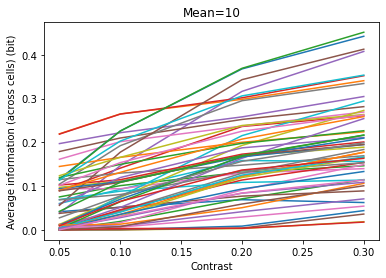

In [60]:
mi = 3
mean_totalEntropy = np.zeros(len(Contrast_list))
mean_noiseEntropy = np.zeros(len(Contrast_list))
for cn in range(60):
    if cn in [3,52,59]: continue
    for ci in range(len(Contrast_list)):
        mean_totalEntropy[ci] = Data2DList[mi][ci]['totalEntropy_Cell'][cn]
        mean_noiseEntropy[ci] = Data2DList[mi][ci]['noiseEntropy_Cell'][cn]
    # plt.plot(Contrast_list,mean_totalEntropy, label = 'Mean='+str(Mean_list[mi]))
    plt.plot(Contrast_list, mean_totalEntropy-mean_noiseEntropy)
    # plt.plot(Contrast_list, (mean_totalEntropy-mean_noiseEntropy)/mean_totalEntropy , label = 'Mean='+str(Mean_list[mi]))
plt.xlabel('Contrast')
plt.title('Mean='+str(Mean_list[mi]))
plt.ylabel('Average information (across cells) (bit)')
# plt.legend()

Text(0, 0.5, 'Average efficiency (across cells)')

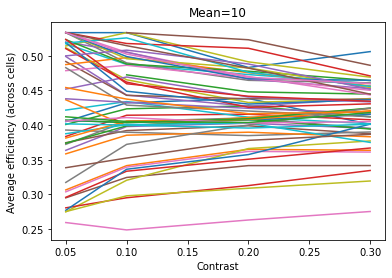

In [61]:
mi = 3
mean_totalEntropy = np.zeros(len(Contrast_list))
mean_noiseEntropy = np.zeros(len(Contrast_list))
for cn in range(60):
    if cn in [3,52,59]: continue
    for ci in range(len(Contrast_list)):
        mean_totalEntropy[ci] = Data2DList[mi][ci]['totalEntropy_Cell'][cn]
        mean_noiseEntropy[ci] = Data2DList[mi][ci]['noiseEntropy_Cell'][cn]
    # plt.plot(Contrast_list,mean_totalEntropy, label = 'Mean='+str(Mean_list[mi]))
    plt.plot(Contrast_list, (mean_totalEntropy-mean_noiseEntropy)/(mean_totalEntropy))
    # plt.plot(Contrast_list, (mean_totalEntropy-mean_noiseEntropy)/mean_totalEntropy , label = 'Mean='+str(Mean_list[mi]))
plt.xlabel('Contrast')
plt.title('Mean='+str(Mean_list[mi]))
plt.ylabel('Average efficiency (across cells)')
# plt.legend()

# CCDM

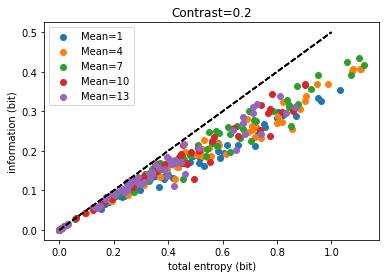

In [62]:
ci = 2
for mi in range(len(Mean_list)):
    if mi == 2 and ci == 3: continue
    totalEntropy_Cell = Data2DList[mi][ci]['totalEntropy_Cell']
    noiseEntropy_Cell = Data2DList[mi][ci]['noiseEntropy_Cell']
    plt.scatter(totalEntropy_Cell,totalEntropy_Cell-noiseEntropy_Cell, label = 'Mean='+str(Mean_list[mi]))
    plt.plot([0, 1.], [0, 0.5], 'k--')
plt.xlabel('total entropy (bit)')
plt.ylabel('information (bit)')
plt.title('Contrast='+str(Contrast_list[ci]))
plt.legend()

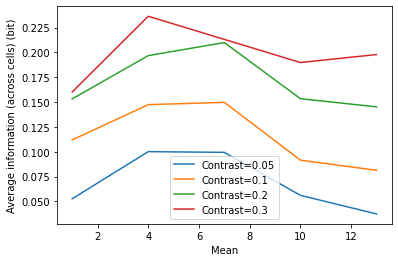

In [63]:
for ci in range(len(Contrast_list)):
    mean_totalEntropy = np.zeros(len(Mean_list))
    mean_noiseEntropy = np.zeros(len(Mean_list))
    for mi in range(len(Mean_list)):
        if mi == 2 and ci == 3: continue
        mean_totalEntropy[mi] = np.mean(np.array(Data2DList[mi][ci]['totalEntropy_Cell']))
        mean_noiseEntropy[mi] = np.mean(np.array(Data2DList[mi][ci]['noiseEntropy_Cell']))
    # plt.plot(Mean_list,mean_totalEntropy, label = 'Contrast='+str(Contrast_list[ci]))
    # plt.plot(Mean_list, mean_totalEntropy-mean_noiseEntropy, label = 'Contrast='+str(Contrast_list[ci]))
    if ci == 3: 
        plt.plot(np.array(Mean_list)[[0,1,3,4]], np.array(mean_totalEntropy-mean_noiseEntropy)[[0,1,3,4]], label = 'Contrast='+str(Contrast_list[ci]))
    else:
        plt.plot(Mean_list, mean_totalEntropy-mean_noiseEntropy, label = 'Contrast='+str(Contrast_list[ci]))
    # plt.plot(Mean_list, (mean_totalEntropy-mean_noiseEntropy)/mean_totalEntropy , label = 'Contrast='+str(Contrast_list[ci]))
plt.xlabel('Mean')
plt.ylabel('Average information (across cells) (bit)')
plt.legend()

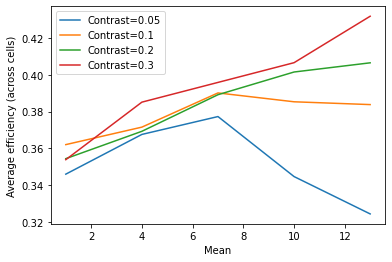

In [64]:
for ci in range(len(Contrast_list)):
    mean_totalEntropy = np.zeros(len(Mean_list))
    mean_noiseEntropy = np.zeros(len(Mean_list))
    for mi in range(len(Mean_list)):
        if mi == 2 and ci == 3: continue
        mean_totalEntropy[mi] = np.mean(np.array(Data2DList[mi][ci]['totalEntropy_Cell']))
        mean_noiseEntropy[mi] = np.mean(np.array(Data2DList[mi][ci]['noiseEntropy_Cell']))
    # plt.plot(Mean_list,mean_totalEntropy, label = 'Contrast='+str(Contrast_list[ci]))
    # plt.plot(Mean_list, mean_totalEntropy-mean_noiseEntropy, label = 'Contrast='+str(Contrast_list[ci]))
    if ci == 3: 
        plt.plot(np.array(Mean_list)[[0,1,3,4]], np.array(mean_totalEntropy-mean_noiseEntropy)[[0,1,3,4]]/np.array(mean_totalEntropy)[[0,1,3,4]], label = 'Contrast='+str(Contrast_list[ci]))
    else:
        plt.plot(Mean_list, (mean_totalEntropy-mean_noiseEntropy)/mean_totalEntropy, label = 'Contrast='+str(Contrast_list[ci]))
    # plt.plot(Mean_list, (mean_totalEntropy-mean_noiseEntropy)/mean_totalEntropy , label = 'Contrast='+str(Contrast_list[ci]))
plt.xlabel('Mean')
plt.ylabel('Average efficiency (across cells)')
plt.legend()

Text(0, 0.5, 'Average information (across cells) (bit)')

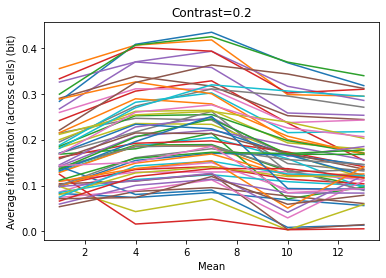

In [65]:
ci = 2
mean_totalEntropy = np.zeros(len(Mean_list))
mean_noiseEntropy = np.zeros(len(Mean_list))
for cn in range(60):
    if cn in [3,52,59]: continue
    for mi in range(len(Mean_list)):
        mean_totalEntropy[mi] = Data2DList[mi][ci]['totalEntropy_Cell'][cn]
        mean_noiseEntropy[mi] = Data2DList[mi][ci]['noiseEntropy_Cell'][cn]
    # plt.plot(Contrast_list,mean_totalEntropy, label = 'Mean='+str(Mean_list[mi]))
    plt.plot(Mean_list, mean_totalEntropy-mean_noiseEntropy)
    # plt.plot(Contrast_list, (mean_totalEntropy-mean_noiseEntropy)/mean_totalEntropy , label = 'Mean='+str(Mean_list[mi]))
plt.title('Contrast='+str(Contrast_list[ci]))
plt.xlabel('Mean')
plt.ylabel('Average information (across cells) (bit)')
# plt.legend()

Text(0, 0.5, 'Average efficiency (across cells)')

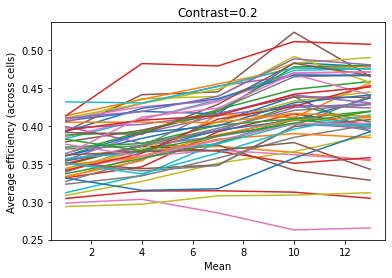

In [66]:
ci = 2
mean_totalEntropy = np.zeros(len(Mean_list))
mean_noiseEntropy = np.zeros(len(Mean_list))
for cn in range(60):
    if cn in [3,52,59]: continue
    for mi in range(len(Mean_list)):
        mean_totalEntropy[mi] = Data2DList[mi][ci]['totalEntropy_Cell'][cn]
        mean_noiseEntropy[mi] = Data2DList[mi][ci]['noiseEntropy_Cell'][cn]
    # plt.plot(Contrast_list,mean_totalEntropy, label = 'Mean='+str(Mean_list[mi]))
    plt.plot(Mean_list, (mean_totalEntropy-mean_noiseEntropy)/mean_totalEntropy)
    # plt.plot(Contrast_list, (mean_totalEntropy-mean_noiseEntropy)/mean_totalEntropy , label = 'Mean='+str(Mean_list[mi]))
plt.title('Contrast='+str(Contrast_list[ci]))
plt.xlabel('Mean')
plt.ylabel('Average efficiency (across cells)')
# plt.legend()

# Test Poison Statistics

Text(0.5, 1.0, 'stimulated')

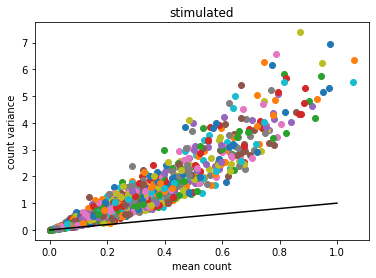

In [67]:
# Sampling Space: all time all trial
winSize = 0.05 # dt = 0.01

for mi in range(len(Mean_list)):
    for ci in range(len(Contrast_list)):
        if mi == 2 and ci == 3: continue
        Spike_Trial_Cell = Data2DList[mi][ci]['Spike_Trial_Cell'].copy()
        for cn in range(60):
            if cn in [3,52,59]: continue
            Spike_Trial = Spike_Trial_Cell[cn]
            rstate_Trial = [0]*trial
            for i in range(trial):
                try:
                    rstate_Trial[i], _ = np.histogram(Spike_Trial[i], np.arange(0,stiTime+winSize,winSize))
                except: # if there is no spike
                    rstate_Trial[i] = np.zeros(int(stiTime/winSize))

            plt.scatter( np.mean(np.array(rstate_Trial).flatten()), np.var(np.array(rstate_Trial).flatten()))

plt.plot([0, 20*winSize], [0, 20*winSize], 'k')
plt.xlabel('mean count')
plt.ylabel('count variance')
plt.title('stimulated')

Text(0.5, 1.0, 'stimulated')

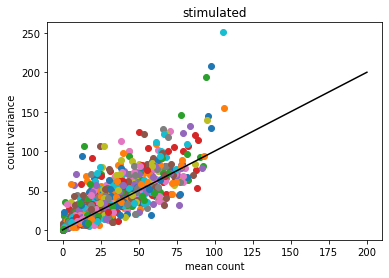

In [68]:
# Sampling Space: all time all trial (window size = a trial)
for mi in range(len(Mean_list)):
    for ci in range(len(Contrast_list)):
        if mi == 2 and ci == 3: continue
        Spike_Trial_Cell = Data2DList[mi][ci]['Spike_Trial_Cell'].copy()
        for cn in range(60):
            if cn in [3,52,59]: continue
            Spike_Trial = Spike_Trial_Cell[cn]
            rstate_Trial = [0]*trial
            for i in range(trial):
                try:
                    rstate_Trial[i] = len(Spike_Trial[i])
                except: # if there is no spike
                    rstate_Trial[i] = 0

            plt.scatter( np.mean(np.array(rstate_Trial)), np.var(np.array(rstate_Trial)))
            if np.var(np.array(rstate_Trial))>=1000:
                print(cn, mi, ci)

plt.plot([0, 200], [0, 200], 'k')
plt.xlabel('mean count')
plt.ylabel('count variance')
plt.title('stimulated')

Text(0.5, 1.0, 'stimulated')

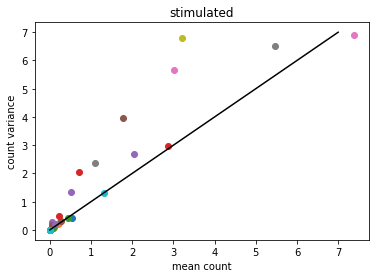

In [69]:
# Sampling Space: a time (event) all trial
winSize = 0.05 # dt = 0.01

mi = 3
ci = 2
Spike_Trial_Cell = Data2DList[mi][ci]['Spike_Trial_Cell'].copy()

cn = 19
Spike_Trial = Spike_Trial_Cell[cn]
rstate_Trial = [0]*trial
for i in range(trial):
    try:
        rstate_Trial[i], _ = np.histogram(Spike_Trial[i], np.arange(0,stiTime+winSize,winSize))
    except: # if there is no spike
        rstate_Trial[i] = np.zeros(int(stiTime/winSize))
for i in range(len(rstate_Trial[i])):
    plt.scatter( np.mean(np.array(rstate_Trial)[:,i]), np.var(np.array(rstate_Trial)[:,i]))

plt.plot([0, 140*winSize], [0, 140*winSize], 'k')
plt.xlabel('mean count')
plt.ylabel('count variance')
plt.title('stimulated')

Text(0.5, 1.0, 'at rest')

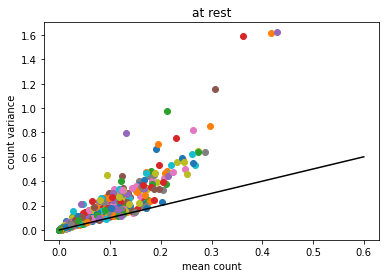

In [89]:
# Sampling Space: all time all trial
winSize = 0.05 # dt = 0.01

for mi in range(len(Mean_list)):
    for ci in range(len(Contrast_list)):
        if mi == 2 and ci == 3: continue
        Spike_Trial_Cell = Data2DList[mi][ci]['rest_Spike_Trial_Cell'].copy()
        for cn in range(60):
            if cn in [3,52,59]: continue
            Spike_Trial = Spike_Trial_Cell[cn]
            rstate_Trial = [0]*trial
            for i in range(trial):
                try:
                    rstate_Trial[i], _ = np.histogram(Spike_Trial[i], np.arange(0,restTime+winSize,winSize))
                except: # if there is no spike
                    rstate_Trial[i] = np.zeros(int(stiTime/winSize))

            plt.scatter( np.mean(np.array(rstate_Trial).flatten()), np.var(np.array(rstate_Trial).flatten()))

plt.plot([0, 12*winSize], [0, 12*winSize], 'k')
plt.xlabel('mean count')
plt.ylabel('count variance')
plt.title('at rest')

Text(0.5, 1.0, 'at rest')

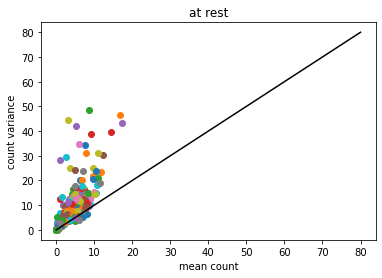

In [71]:
# all time all trial (window size = a trial)
for mi in range(len(Mean_list)):
    for ci in range(len(Contrast_list)):
        if mi == 2 and ci == 3: continue
        Spike_Trial_Cell = Data2DList[mi][ci]['rest_Spike_Trial_Cell'].copy()
        for cn in range(60):
            if cn in [3,52,59]: continue
            Spike_Trial = Spike_Trial_Cell[cn]
            rstate_Trial = [0]*trial
            for i in range(trial):
                try:
                    rstate_Trial[i] = len(Spike_Trial[i])
                except: # if there is no spike
                    rstate_Trial[i] = 0

            plt.scatter( np.mean(np.array(rstate_Trial)), np.var(np.array(rstate_Trial)))

plt.plot([0, 80], [0, 80], 'k')
plt.xlabel('mean count')
plt.ylabel('count variance')
plt.title('at rest')

Text(0.5, 1.0, 'at rest')

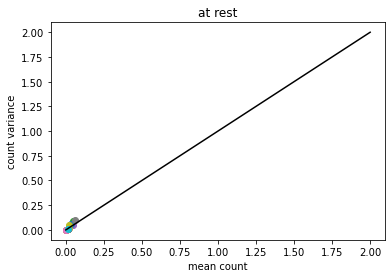

In [90]:
# Sampling Space: a time (event) all trial
winSize = 0.1 # dt = 0.01

mi = 3
ci = 2
Spike_Trial_Cell = Data2DList[mi][ci]['rest_Spike_Trial_Cell'].copy()

cn = 53
Spike_Trial = Spike_Trial_Cell[cn]
rstate_Trial = [0]*trial
for i in range(trial):
    try:
        rstate_Trial[i], _ = np.histogram(Spike_Trial[i], np.arange(0,restTime+winSize,winSize))
    except: # if there is no spike
        rstate_Trial[i] = np.zeros(int(stiTime/winSize))
for i in range(len(rstate_Trial[i])):
    plt.scatter( np.mean(np.array(rstate_Trial)[:,i]), np.var(np.array(rstate_Trial)[:,i]))

plt.plot([0, 20*winSize], [0, 20*winSize], 'k')
plt.xlabel('mean count')
plt.ylabel('count variance')
plt.title('at rest')